In [21]:
from aemeasure import read_as_pd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()


In [22]:
from pcpptc import PolygonInstance, Solution
from pcpptc.plot import setup_plot, plot_polygon_instance, plot_solution
from pcpptc.plot.polgyon_instance import plot_coverage

In [23]:
read_as_pd("./solutions2/2.results.json").columns

Loaded dataframe ./solutions2/2.results.json
Executed on: ['algry03' 'algry01']
During: 2021-08-20 16:20:25.305058 and 2021-08-23 19:12:10.324509


Index(['solution', 'coverage', 'touring_cost', 'length', 'turn_sum',
       'instance', 'instance_path', 'runtime', 'timestamp', 'hostname', 'argv',
       'git_revision', 'cwd', 'solver', 'i', 'turn_factor'],
      dtype='object')

In [24]:
tables = []
for f in os.listdir("./solutions2"):
    if not f.endswith(".results.json"):
        continue
    f = os.path.join("./solutions2", f)
    tables.append(read_as_pd(f))

data = pd.concat(tables, ignore_index=True)
data.groupby(["solver"])["instance"].nunique()

Loaded dataframe ./solutions2/75.results.json
Executed on: ['algry01']
During: 2021-08-23 21:15:25.537704 and 2021-08-23 21:18:47.477030
Loaded dataframe ./solutions2/156.results.json
Executed on: ['algry01']
During: 2021-08-23 17:28:07.922508 and 2021-08-23 17:29:58.018417
Loaded dataframe ./solutions2/119.results.json
Executed on: ['algry01']
During: 2021-08-23 21:52:15.380986 and 2021-08-23 22:01:16.874869
Loaded dataframe ./solutions2/173.results.json
Executed on: ['algry01']
During: 2021-08-23 21:37:08.068632 and 2021-08-23 21:42:46.264003
Loaded dataframe ./solutions2/144.results.json
Executed on: ['algry03' 'algry01']
During: 2021-08-20 16:24:14.480837 and 2021-08-23 19:20:55.900008
Loaded dataframe ./solutions2/185.results.json
Executed on: ['algry01']
During: 2021-08-23 22:28:15.147155 and 2021-08-23 22:31:34.907581
Loaded dataframe ./solutions2/154.results.json
Executed on: ['algry01']
During: 2021-08-23 20:02:03.554251 and 2021-08-23 20:07:16.064666
Loaded dataframe ./soluti

solver
MeshAlgorithm(0.95)                                                                                                   64
MeshAlgorithm(0.95, full_coverage=False)                                                                             199
MeshAlgorithm(0.95, full_coverage=True)                                                                              199
RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=False, point_based=False, with_boundary=False))    199
RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=True, point_based=False, with_boundary=False))     199
Name: instance, dtype: int64

In [25]:
data.dropna(inplace=True)
data = data[data["solver"] != "MeshAlgorithm(0.95)"]
data.groupby(["solver"])["instance"].nunique()

solver
MeshAlgorithm(0.95, full_coverage=False)                                                                             199
MeshAlgorithm(0.95, full_coverage=True)                                                                              199
RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=False, point_based=False, with_boundary=False))    199
RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=True, point_based=False, with_boundary=False))     199
Name: instance, dtype: int64

In [26]:
from pcpptc.instance_converter.dmsh import GmshGrid


def rename(s):
    names = {
        "RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=False, point_based=False, with_boundary=False))": "Regular (Partial)",
        "RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=True, point_based=False, with_boundary=False))": "Regular (Full)",
        "MeshAlgorithm(0.95, full_coverage=False)": "Mesh (Partial)",
        "MeshAlgorithm(0.95, full_coverage=True)": "Mesh (Full)",
    }
    return names.get(s, s)


data["solver"] = data["solver"].apply(rename)

In [27]:
data = data[data["solver"] == "Regular (Full)"]

In [28]:
instance_paths = list(data["instance_path"].unique())
instances = {f: PolygonInstance.from_json(file_path=f) for f in instance_paths}
instance_areas = pd.DataFrame(
    data={"area": [i.original_area.area for i in instances.values()]},
    index=instance_paths,
)
data = data.merge(instance_areas, left_on="instance_path", right_index=True)
t_ = data.groupby("instance")[["touring_cost"]].min()
data = data.merge(t_, left_on="instance", right_index=True, suffixes=("", "_min"))
data["relative_cost"] = 100 * ((data["touring_cost"] / data["touring_cost_min"]) - 1)
data["relative_coverage"] = 100 * data["coverage"] / data["area"]
data["type"] = data["solver"].apply(lambda s: s[0])

In [29]:
t = data.sample(35).reindex()
instances = [
    PolygonInstance.from_json(file_path=instance)
    for instance in t["instance_path"].unique()
]
max_value = 0.5 * max(
    max((v[1] for v in instance.valuable_areas), default=0.0) for instance in instances
)
max_expense = max(
    max((v[1] for v in instance.expensive_areas), default=0.0) for instance in instances
)

In [36]:
def plot(row, path=None, ax=None):
    instance_path = row["instance_path"]
    instance = PolygonInstance.from_json(file_path=instance_path)
    solution = Solution.from_json(data=row["solution"])
    if not ax:
        ax = setup_plot(figsize=(4.5, 4.5))
    plot_polygon_instance(
        ax,
        instance,
        set_limits=True,
        relative_value=max_value,
        relative_expense=max_expense,
        plot_valuable_areas=False,
    )
    plot_solution(ax, solution, color="blue")
    plot_coverage(ax, instance, solution)
    ax.set_title(f"Coverage: {round(row['relative_coverage'],1)}%")
    if path:
        plt.tight_layout()
        plt.savefig(path)

Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage polygon
Computing coverage polygon
Plotting coverage p

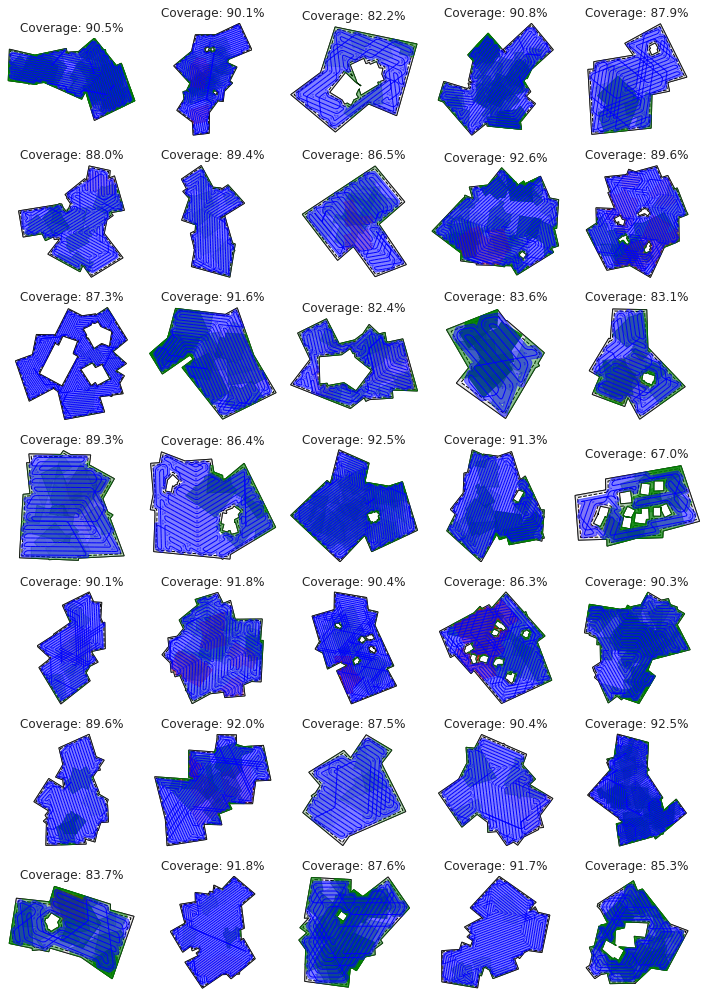

In [37]:
fig, axes = plt.subplots(7, 5, figsize=(10, 14))
plt.tight_layout()
for i in range(0, 35):
    # ax = axes[i//5, i%5]
    ax = axes[i // 5, i % 5]
    ax.set_aspect("equal", adjustable="box")
    # plot_polygon_instance(ax, instances[i],set_limits=False)
    plot(t.iloc[i], ax=ax)
    ax.axis("off")
plt.autoscale()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=-0.2, hspace=-0.2)
plt.tight_layout()
plt.show()

./instances2/122.instance.json
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

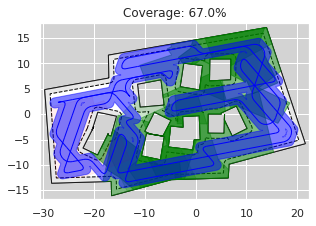

./instances2/67.instance.json
Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

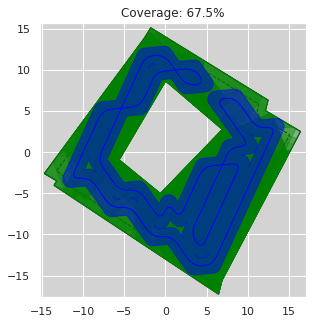

In [43]:
t = data[data["relative_coverage"] <= 70]
t
for i, row in t.iterrows():
    print(row["instance_path"])
    plot(row)
    plt.show()